In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense
import tensorflow as tf


import utils
from layers import FFDense
from models import FFNetwork

60000 training examples
10000 testing examples


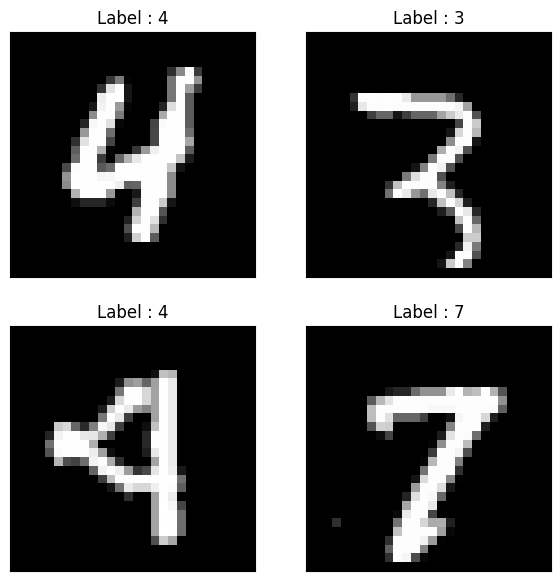

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f'{x_train.shape[0]} training examples\n{x_test.shape[0]} testing examples')

train_dataset = Dataset.from_tensor_slices((x_train, y_train))
test_dataset = Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)

utils.show_samples(x_train, y_train)

## Back propagation model

For comparison with the Forward-Foward algorithm

In [3]:
clf = Sequential([InputLayer(input_shape=(28, 28)),
                  Flatten(),
                  Dense(10, activation='softmax')])
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
938/938 [==============================] - 2s 2ms/step - loss: 0.5552 - accuracy: 0.8582
Epoch 2/100
938/938 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.9082
Epoch 3/100
938/938 [==============================] - 2s 2ms/step - loss: 0.3013 - accuracy: 0.9162
Epoch 4/100
938/938 [==============================] - 1s 2ms/step - loss: 0.2872 - accuracy: 0.9199
Epoch 5/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2785 - accuracy: 0.9221
Epoch 6/100
938/938 [==============================] - 2s 2ms/step - loss: 0.2724 - accuracy: 0.9238
Epoch 7/100
938/938 [==============================] - 1s 2ms/step - loss: 0.2679 - accuracy: 0.9250
Epoch 8/100
938/938 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.9262
Epoch 9/100
938/938 [==============================] - 1s 2ms/step - loss: 0.2612 - accuracy: 0.9271
Epoch 10/100
938/938 [==============================] - 1s 2ms/step - loss: 0.2587 - accura

## Evaluation of the back propagation model

157/157 [==============================] - 0s 1ms/step - loss: 0.2919 - accuracy: 0.9246
Test Accuracy Score:  92.46%


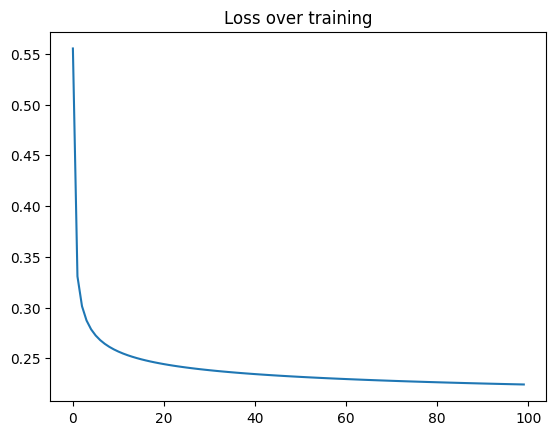

In [4]:
_, accuracy = clf.evaluate(test_dataset, verbose=1)
print(f'Test Accuracy Score: {accuracy * 100: .2f}%')

plt.plot(range(len(history.history["loss"])), history.history["loss"])
plt.title("Loss over training")
plt.show()

313/313 [==============================] - 0s 1ms/step


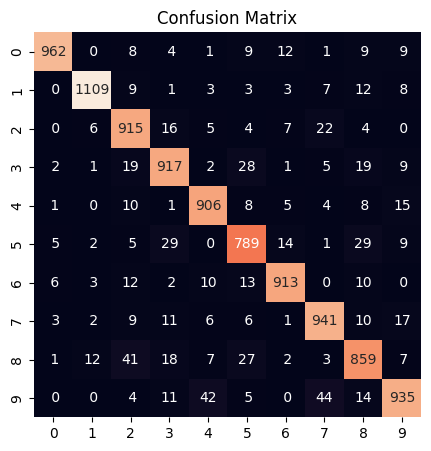

In [5]:
plt.figure(figsize=(5, 5))
preds = clf.predict(tf.convert_to_tensor(x_test))
preds = np.argmax(preds, axis=1)
cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, annot=True, fmt='2d', cbar=False, cmap='rocket')
plt.title('Confusion Matrix')
plt.show()

Look at the top four misclassified examples

Predicted: 9 Actual: 7


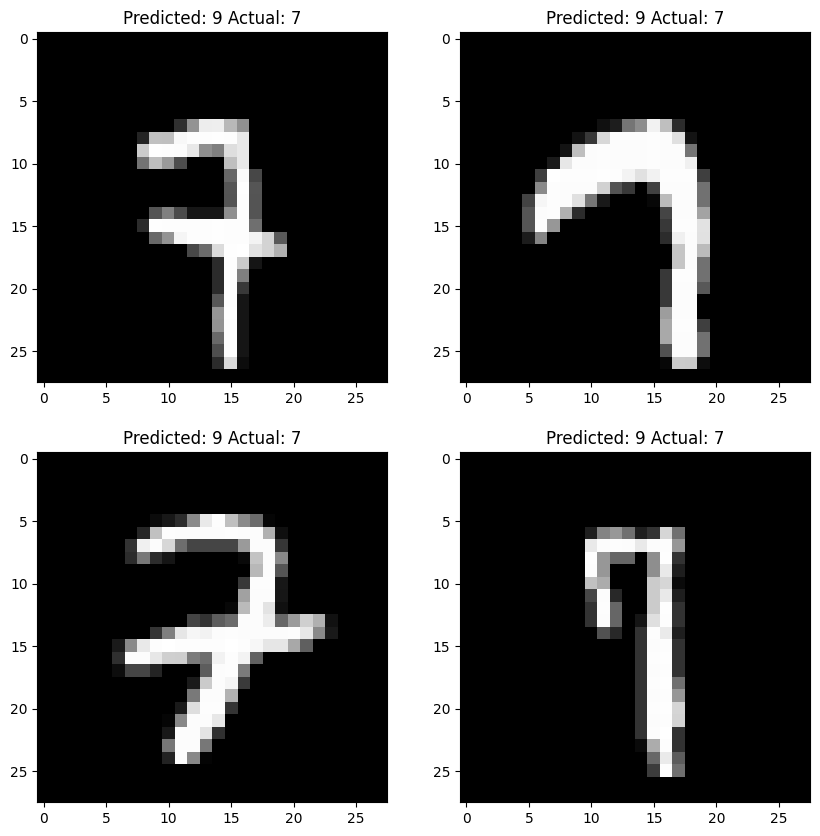

Predicted: 9 Actual: 4


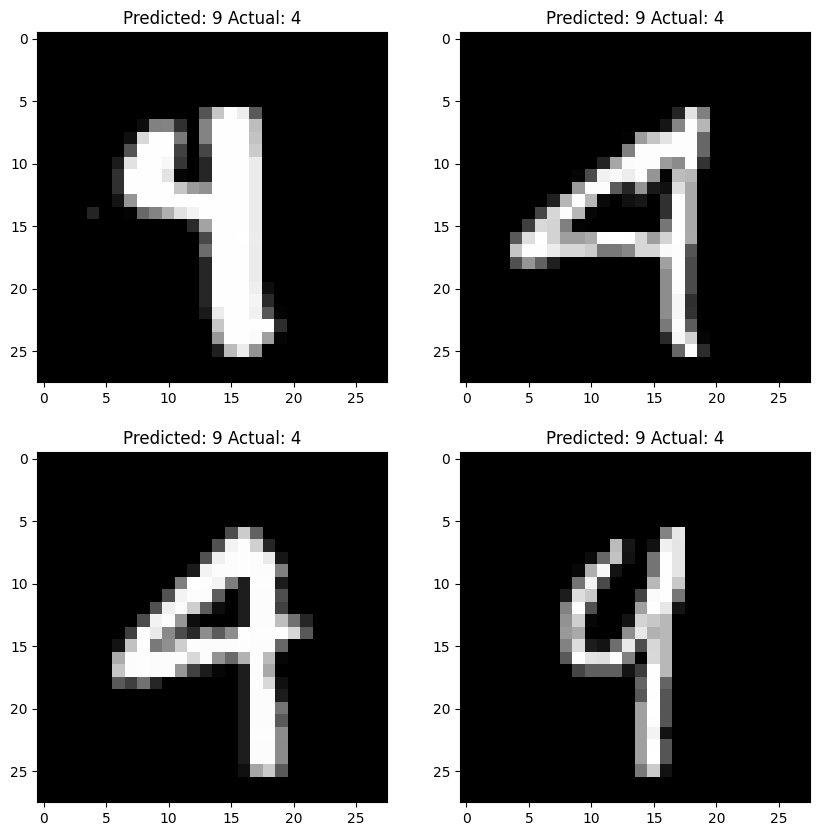

Predicted: 8 Actual: 2


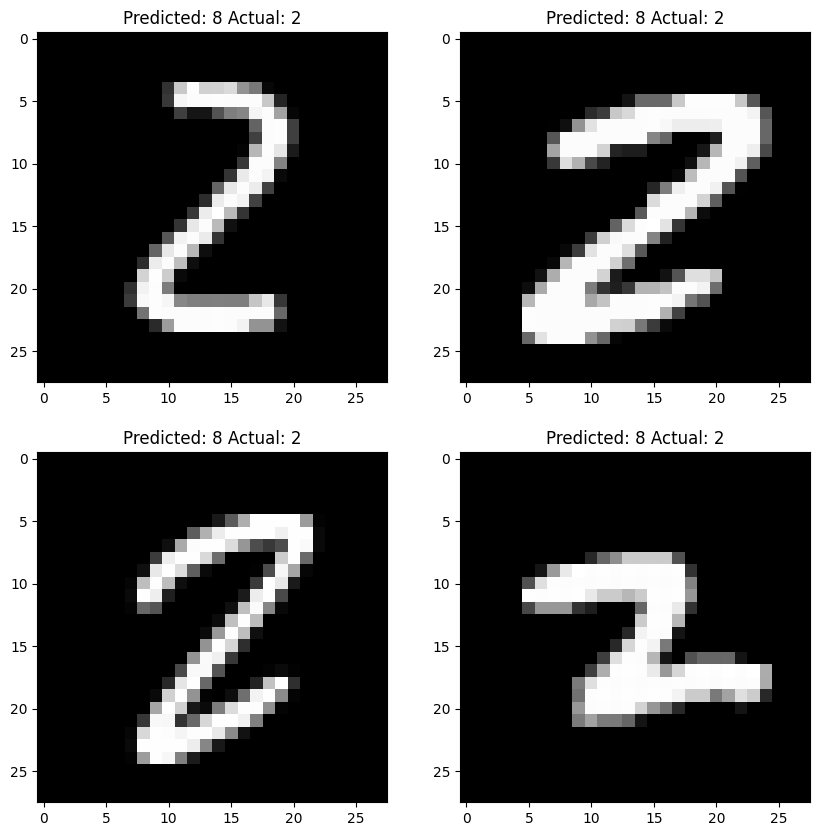

Predicted: 5 Actual: 8


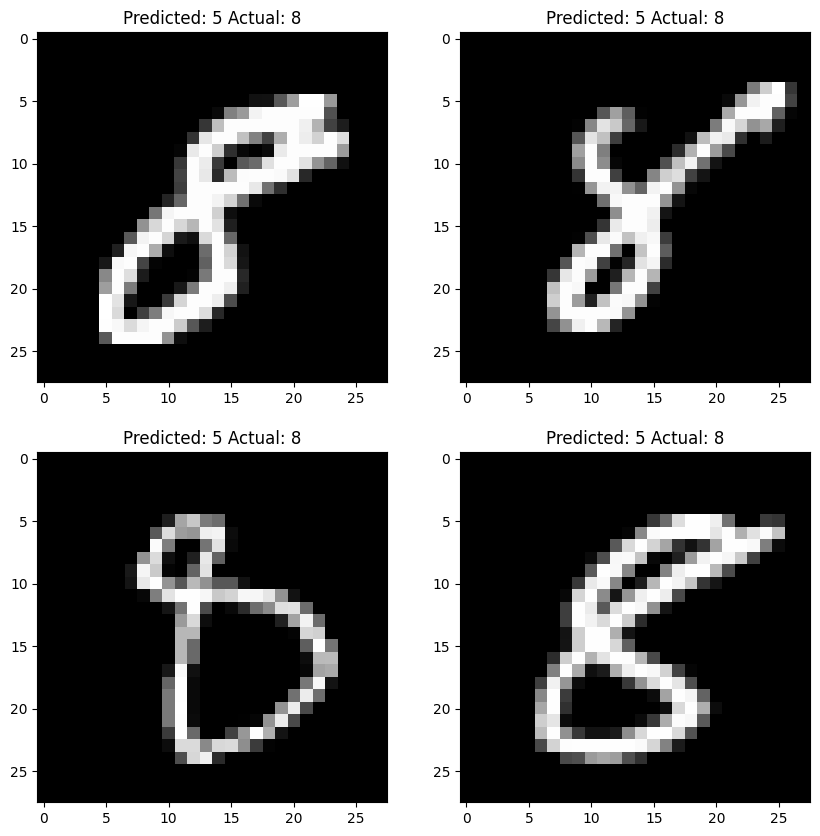

In [6]:
y_hat = np.squeeze(preds)
misses_df, top_errors = utils.get_worst(y_hat, y_test, 4)

data = (x_test, y_hat, y_test)

for predicted, actual in top_errors.index.tolist():
    print(f'Predicted: {predicted} Actual: {actual}')
    utils.compare(predicted, actual, data, misses_df)

## Build and train the Forward-Foward model!

In [10]:
model = FFNetwork([784, 10], iterations=1)

model.compile(
    optimizer=Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[Mean()],
)

In [11]:
history = model.fit(train_dataset, epochs=100, verbose=1)

Epoch 1/100
Training layer 1 now : 
Training layer 1 now : 
938/938 [==============================] - 4s 3ms/step - FinalLoss: 0.6926
Epoch 2/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.5771
Epoch 3/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.5146
Epoch 4/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4803
Epoch 5/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.4583
Epoch 6/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4424
Epoch 7/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4301
Epoch 8/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.4206
Epoch 9/100
938/938 [==============================] - 3s 3ms/step - FinalLoss: 0.4130
Epoch 10/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 0.4069
Epoch 11/100
938/938 [==============================] - 2s 3ms/step - FinalLoss: 

## Model Evaluation

Test Accuracy score:  90.62%


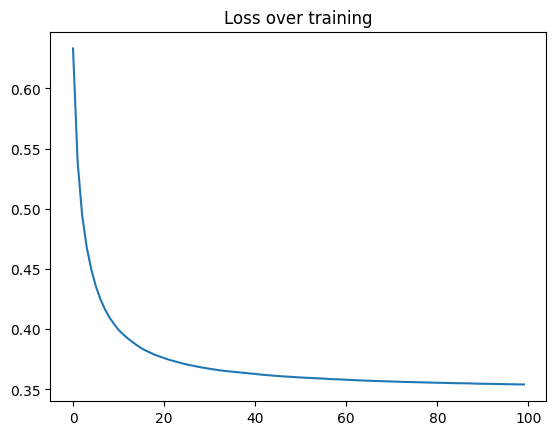

In [12]:
preds = model.predict(tf.convert_to_tensor(x_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))
results = accuracy_score(preds, y_test)
print(f"Test Accuracy score: {results*100: .2f}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

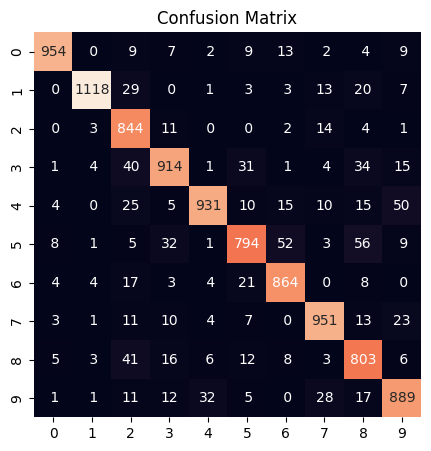

In [13]:
plt.figure(figsize=(5, 5))
cm = confusion_matrix(preds, y_test)
sns.heatmap(cm, annot=True, fmt='2d', cbar=False, cmap='rocket')
plt.title('Confusion Matrix')
plt.show()

### Looking at the errors

We can compare the predicted and actual labels for the top four misclassified examples.

Predicted: 5 Actual: 8


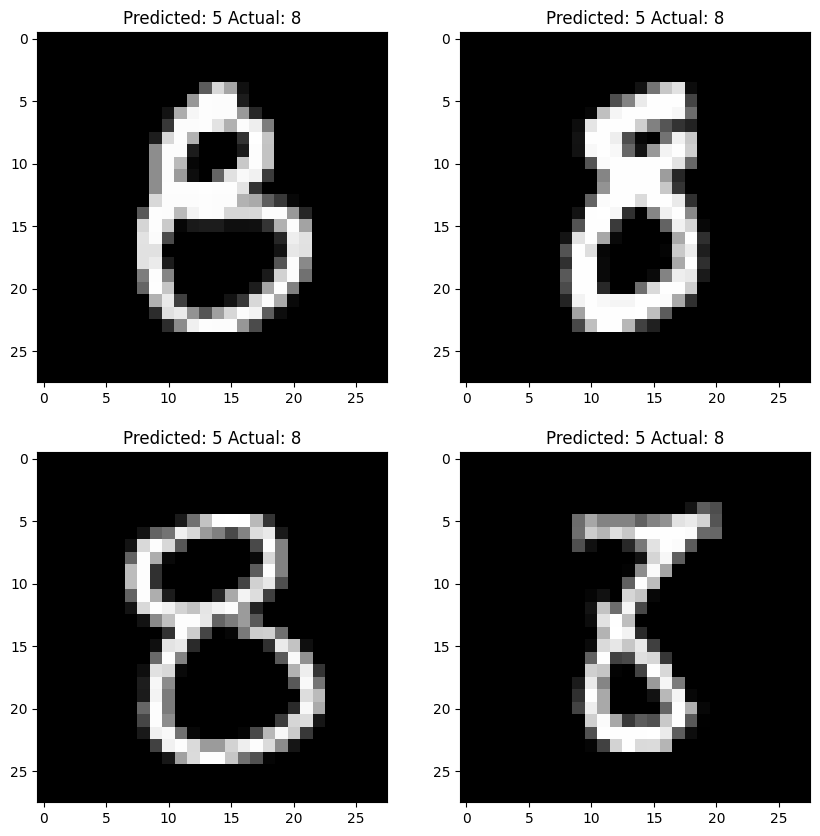

Predicted: 5 Actual: 6


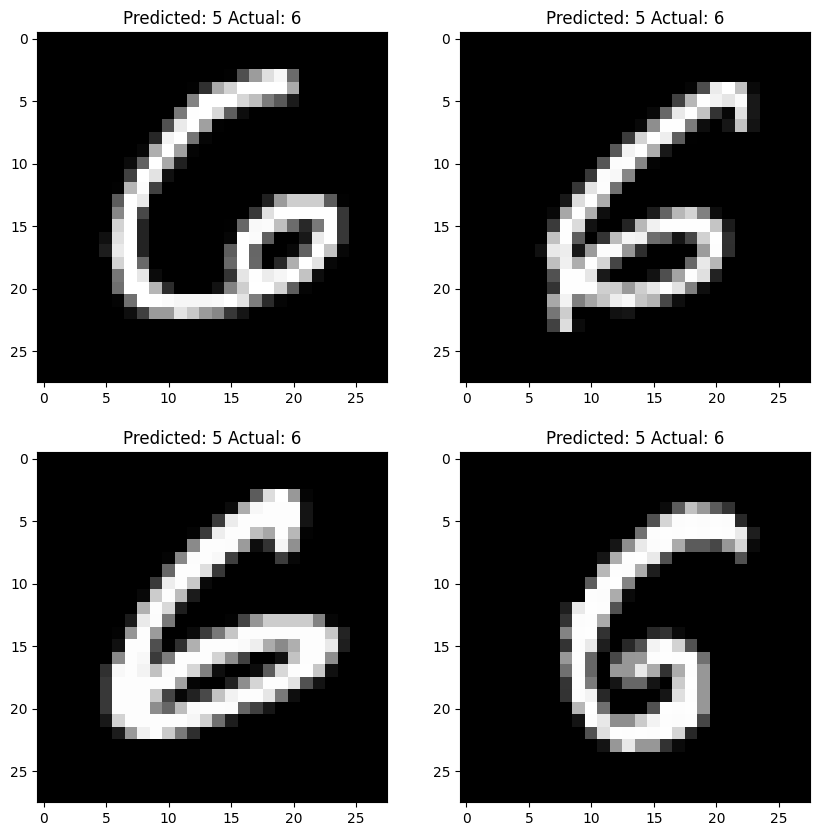

Predicted: 4 Actual: 9


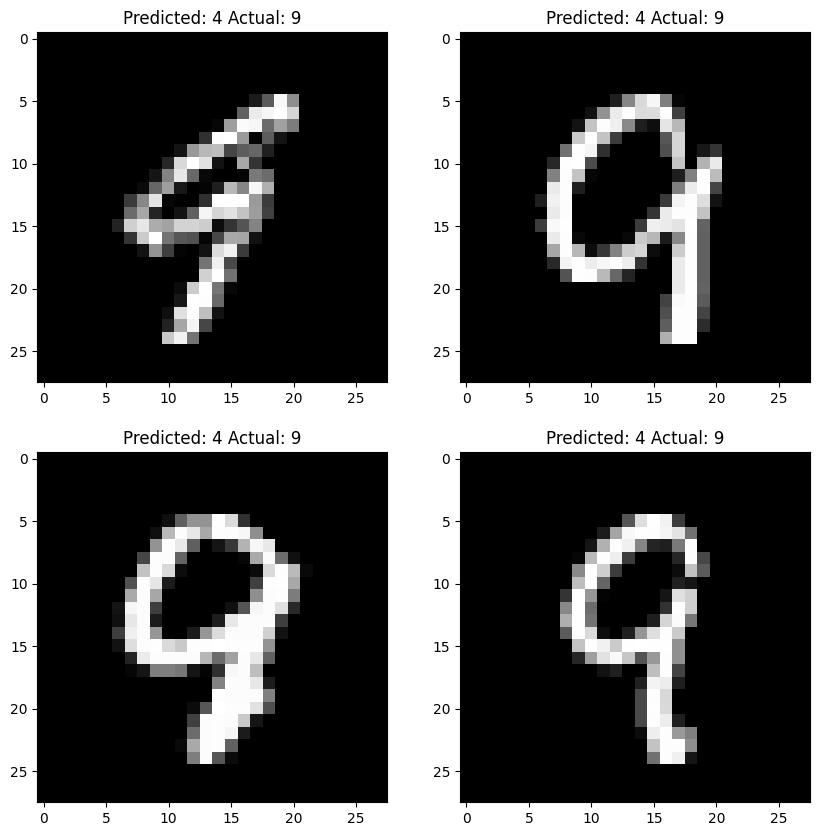

Predicted: 8 Actual: 2


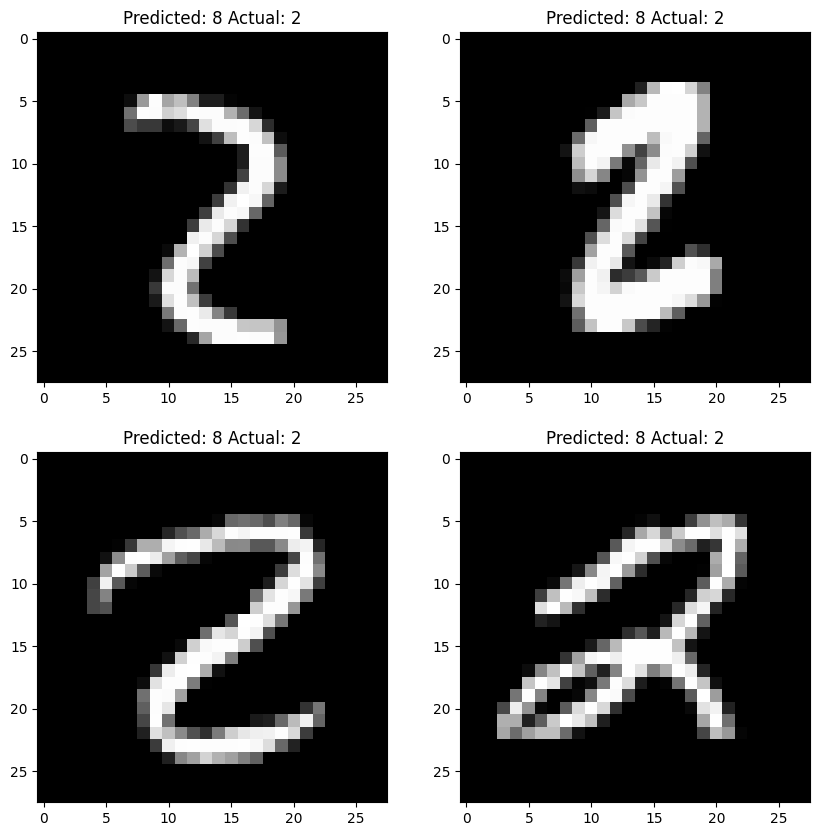

In [15]:
y_hat = np.squeeze(preds)
misses_df, top_errors = utils.get_worst(y_hat, y_test, 4)

data = (x_test, y_hat, y_test)

for predicted, actual in top_errors.index.tolist():
    print(f'Predicted: {predicted} Actual: {actual}')
    utils.compare(predicted, actual, data, misses_df)
